<a href="https://colab.research.google.com/github/eikeschuett/IcebergShipDetection/blob/DNN_Trial_and_Error/CNN_test_different_optimizers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance
from keras_preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.optimizers import Adam, SGD, RMSprop


Mount drive and import data

In [2]:
drive.mount('/content/drive')
data = pd.read_json('/content/drive/MyDrive/Iceberg_Ship_Classification/train.json')
print(data.columns)

Mounted at /content/drive
Index(['id', 'band_1', 'band_2', 'inc_angle', 'is_iceberg'], dtype='object')


Define a function for the lee filter

In [3]:
def lee_filter(img, size):
    # From here: https://stackoverflow.com/questions/39785970/speckle-lee-filter-in-python
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    return img_output

Define a function which prepares the data. The function reshapes each image into the correct 75x75 pixels format and creates a third band with the total backscater (HH+HV). It also applies a denoising filter, rescales the pixel values between 0 and 1 and stacks the three bands in a single image. The dataset is then split into separate parts for for training (70 %), validation (20 %) and testing (10%).

In [4]:
def prepare_data(data, filter):
  # data["inc_angle"] = data["inc_angle"].replace(["na"], np.nan)

  # Get the labels (y-values)
  labels = np.array(data["is_iceberg"])

  # Create empty list for the images
  imgs = []
  for i, row in data.iterrows():
      # Reshape list to image
      hh  = np.reshape(row["band_1"], (75, 75))
      hv  = np.reshape(row["band_2"], (75, 75))
      b3  = hh + hv
      
      if filter == "bilateral":
        # Denoise images with bilteral fitler
        hh = denoise_bilateral(hh, sigma_color=0.10, sigma_spatial=5)
        hv = denoise_bilateral(hv, sigma_color=0.10, sigma_spatial=5)
        b3 = denoise_bilateral(b3, sigma_color=0.10, sigma_spatial=5)
      elif filter == "lee":
        hh = lee_filter(hh, 20)
        hv = lee_filter(hv, 20)
        b3 = lee_filter(b3, 20)
      elif filter == "gaussian":
        hh = ndimage.gaussian_filter(hh, 1)
        hv = ndimage.gaussian_filter(hv, 1)
        b3 = ndimage.gaussian_filter(b3, 1)
      else:
        print('Filter not available. Use "bilateral", "lee" or "gaussian" instead.')
        raise
        
      # Rescale images between 0 and 1 for faster convergence rate
      hh = (hh - hh.min())/(hh.max()-hh.min())
      hv = (hv - hv.min())/(hv.max()-hv.min())
      b3 = (b3 - b3.min())/(b3.max()-b3.min())      

      # Stack the bands and append them to imgs
      imgs.append(np.dstack((hh, hv, b3)))
      
  # Split dataset into training (70%)  and validation (30 %)
  x_train, x_val, y_train, y_val = train_test_split(imgs, 
                                                    labels, 
                                                    test_size=0.3, 
                                                    random_state=42)
  # Then split validation dataset into validation (20 %) and testing (10 %)
  x_val, x_test, y_val, y_test = train_test_split(x_val,
                                                  y_val,
                                                  test_size=(1/3),
                                                  random_state=42)

  x_train = np.array(x_train)
  x_test = np.array(x_test)
  x_val = np.array(x_val)
  return x_train, x_val, x_test, y_train, y_val, y_test

Next, define a function for the data generators.

In [5]:
def DataGenerators(x_train, x_val, y_train, y_val):
  training_datagen = ImageDataGenerator(
      rotation_range = 90,
      width_shift_range = 0.2,
      height_shift_range = 0.2,
      shear_range = 0.2,
      zoom_range = 0.2,
      horizontal_flip = True,
      fill_mode = 'nearest')

  train_generator = training_datagen.flow(x_train, y_train)#,
                                      #batch_size=64)#, 
                                      #subset = "training")

  val_datagen = ImageDataGenerator()

  val_generator = val_datagen.flow(x_val, y_val)#,
                                      #batch_size=16)#, 
                                      #subset = "training")
  
  return train_generator, val_generator

Function to create a model

In [6]:
def create_model():
  model = tf.keras.models.Sequential([
      # Note the input shape is the desired size of the image 75x75 with 3 bytes color
      # This is the first convolution
      tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(75, 75, 3)),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Dropout(0.2),
      # The second convolution
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Dropout(0.1),
      # The third convolution
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Dropout(0.1),
      # The fourth convolution
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Dropout(0.2),
      # Flatten the results to feed into a DNN
      tf.keras.layers.Flatten(),
      # 512 neuron hidden layer
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.BatchNormalization(renorm=True),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      #tf.keras.layers.Dense(128, activation='relu'),
      # Only 1 output neuron. It will contain a value from 0-1 where 0 means ship and 1 means iceberg
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  return model

Functions to compile and train the model

In [22]:
def compile_model(model, loss_function, optimizer):
  model.compile(loss=loss_function,
                optimizer=optimizer,
                metrics=['accuracy'])
  return model

def run_model(model, train_generator, val_generator):
  history = model.fit(
        train_generator,
        #steps_per_epoch=10,  
        epochs=250,
        verbose=1,
        validation_data = val_generator)#,
        #validation_steps=10)
  return model, history  

## Training
Now prepare the data and return the number of samples for training, validation and testing.

In [8]:
x_train, x_val, x_test, y_train, y_val, y_test = prepare_data(data,"lee")
print("Number of samples for training: " + str(len(x_train)))
print("Number of samples for validation: " + str(len(x_val)))
print("Number of samples for testing: " + str(len(x_test)))

Number of samples for training: 1122
Number of samples for validation: 321
Number of samples for testing: 161


Run the model for different optimizers

In [23]:
# Binary crossentropy + RMSProp
loss_function = 'binary_crossentropy'
optimizer=RMSprop()

train_generator, val_generator = DataGenerators(x_train, x_val, y_train, y_val)
model_rms = create_model()
model_rms = compile_model(model_rms, loss_function, optimizer)
model_rms, history_rms = run_model(model_rms, train_generator, val_generator)

# Binary crossentropy + Adam
loss_function = 'binary_crossentropy'
optimizer=Adam()#lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

train_generator, val_generator = DataGenerators(x_train, x_val, y_train, y_val)
model_bce = create_model()
model_bce = compile_model(model_bce, loss_function, optimizer)
model_bce, history_bce = run_model(model_bce, train_generator, val_generator)

# Binary crossentropy + SGD
loss_function = 'binary_crossentropy'
optimizer=SGD()

train_generator, val_generator = DataGenerators(x_train, x_val, y_train, y_val)
model_sgd = create_model()
model_sgd = compile_model(model_sgd, loss_function, optimizer)
model_sgd, history_sgd = run_model(model_sgd, train_generator, val_generator)

# Binary crossentropy + SGD with nesterov momentum
loss_function = 'binary_crossentropy'
optimizer=SGD(nesterov=True)

train_generator, val_generator = DataGenerators(x_train, x_val, y_train, y_val)
model_sgdm = create_model()
model_sgdm = compile_model(model_sgdm, loss_function, optimizer)
model_sgdm, history_sgdm = run_model(model_sgdm, train_generator, val_generator)

Epoch 1/250
36/36 [==============================] - 3s 56ms/step - loss: 1.0127 - accuracy: 0.5154 - val_loss: 0.6999 - val_accuracy: 0.5545
Epoch 2/250
36/36 [==============================] - 2s 49ms/step - loss: 0.8226 - accuracy: 0.5271 - val_loss: 0.6366 - val_accuracy: 0.6449
Epoch 3/250
36/36 [==============================] - 2s 50ms/step - loss: 0.7111 - accuracy: 0.5894 - val_loss: 0.5311 - val_accuracy: 0.7383
Epoch 4/250
36/36 [==============================] - 2s 50ms/step - loss: 0.7246 - accuracy: 0.6227 - val_loss: 0.6707 - val_accuracy: 0.6012
Epoch 5/250
36/36 [==============================] - 2s 50ms/step - loss: 0.6395 - accuracy: 0.6739 - val_loss: 0.6699 - val_accuracy: 0.7414
Epoch 6/250
36/36 [==============================] - 2s 51ms/step - loss: 0.6399 - accuracy: 0.6915 - val_loss: 0.5298 - val_accuracy: 0.7570
Epoch 7/250
36/36 [==============================] - 2s 51ms/step - loss: 0.6005 - accuracy: 0.6985 - val_loss: 0.4616 - val_accuracy: 0.7726
Epoch 

Evaluate the model on the testdata

In [24]:
results_bce = model_bce.evaluate(x_test, y_test)
results_sgd = model_sgd.evaluate(x_test, y_test)
results_sgdm = model_sgdm.evaluate(x_test, y_test)
results_rms = model_rms.evaluate(x_test, y_test)
print("BCE: test loss, test acc:", results_bce)
print("SGD: test loss, test acc:", results_sgd)
print("SGD with Nesterov momentum: test loss, test acc:", results_sgdm)
print("RMS: test loss, test acc:", results_rms)


6/6 [==============================] - 0s 5ms/step - loss: 0.3335 - accuracy: 0.8696
BCE: test loss, test acc: [0.3452146649360657, 0.8322981595993042]
SGD: test loss, test acc: [0.37178534269332886, 0.8385093212127686]
SGD with Nesterov momentum: test loss, test acc: [0.29938504099845886, 0.8819875717163086]
RMS: test loss, test acc: [0.33349984884262085, 0.8695651888847351]


Define a function to easily plot the results

In [25]:
def plot_graphs(history, string, x, y, n, label):
  fig.add_subplot(x,y,n)
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.ylim([0,1])
  plt.grid()
  if string=="accuracy":
    plt.title(label)

Now plot the results

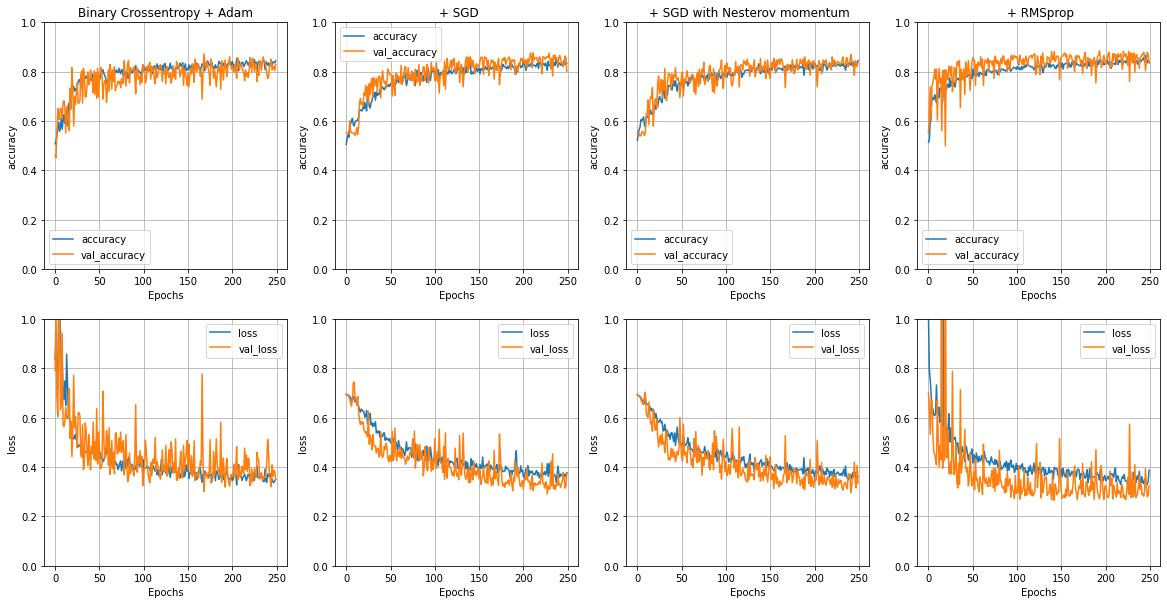

In [26]:
fig = plt.figure(figsize=(20,10))
plot_graphs(history_bce, "accuracy", 2, 4, 1, "Binary Crossentropy + Adam")
plot_graphs(history_sgd, "accuracy", 2, 4, 2, " + SGD")
plot_graphs(history_sgdm, "accuracy", 2, 4, 3, " + SGD with Nesterov momentum")
plot_graphs(history_rms, "accuracy", 2, 4, 4, " + RMSprop")

plot_graphs(history_bce, "loss", 2, 4, 5, "Binary Crossentropy + Adam")
plot_graphs(history_sgd, "loss", 2, 4, 6, " + SGD")
plot_graphs(history_sgdm, "loss", 2, 4, 7, " + SGD with Nesterov momentum")
plot_graphs(history_rms, "loss", 2, 4, 8, " + RMSprop")